## Segmentation masks

In [18]:
import json
import numpy as np
import cv2
from pycocotools import mask as maskUtils
from PIL import Image
import matplotlib.pyplot as plt
import os

In [10]:
with open('./coco-annotator/datasets/drone_imagens/.exports/coco-1726524595.6018302.json') as f:
    coco_data = json.load(f)

In [11]:
img_height= 400
img_width=400

In [13]:
def create_mask(annotations, height, width):

    mask = np.zeros((height, width), dtype=np.uint8)

    for annotation in annotations:
        segmentation = annotation['segmentation']
        for polygon in segmentation:
            polygon = np.array(polygon).reshape((-1,2)).astype(np.int32)
            cv2.fillPoly(mask, [polygon], color=1)
            
    return mask

In [21]:
mask_dir = 'masks/'
for image in coco_data['images']:
    image_id = image['id']
    file_name = image['file_name']
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

    mask = create_mask(annotations, img_height, img_width)

    mask_image=Image.fromarray(mask*255)
    if not os.path.exists(mask_dir):
        os.makedirs(mask_dir)

    mask_image.save(f"./masks/{file_name}")

In [27]:
mask = './masks/chunk_0_2800.jpg'
mask_image = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)

mask_image = np.array(mask_image, dtype=np.uint8)


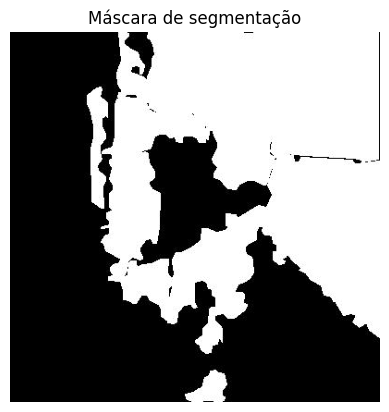

In [29]:
plt.imshow(mask_image, cmap='gray')
plt.title('Máscara de segmentação')
plt.axis('off')  # Hide axis
plt.show()

## Using U-net

In [41]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from PIL import Image
import torchvision.transforms as transforms
import torch



In [90]:
model = smp.Unet(
    encoder_name='resnext101_32x32d',
    encoder_weights='instagram',
    in_channels=3,
    classes=1,
)

Downloading: "https://download.pytorch.org/models/ig_resnext101_32x32-e4b90b00.pth" to C:\Users\luana/.cache\torch\hub\checkpoints\ig_resnext101_32x32-e4b90b00.pth
100%|██████████| 1.75G/1.75G [05:15<00:00, 5.95MB/s]


In [91]:

# preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')

model.eval()

transform = transforms.Compose([
    transforms.Resize((416,416)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.456,0.456,0.406], std=[0.229, 0.224, 0.225])

])

o_image_path='./output_chunks/filled_chunks/chunk_0_2800.jpg'

In [92]:
image = Image.open(o_image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0)

In [93]:
with torch.no_grad():
    output=model(image_tensor)
    predicted_mask=torch.sigmoid(output)
    predicted_mask = (predicted_mask>0.5).float()

In [94]:
# predicted_mask_np=predicted_mask.squeeze().numpy()
# predicted_mask_np_0 = predicted_mask_np[0]

predicted_mask_np = predicted_mask.squeeze().cpu().numpy()

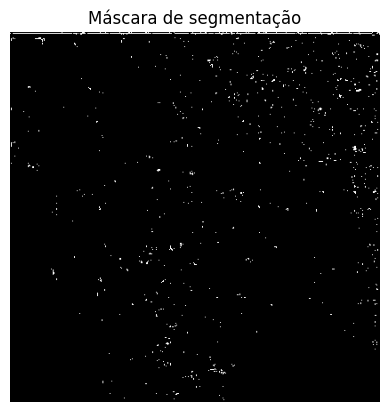

In [95]:
plt.imshow(predicted_mask_np, cmap='gray')
plt.title('Máscara de segmentação')
plt.axis('off')  # Hide axis
plt.show()